In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Imports
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
 # reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
 # View all of the classes that automap found
Base.classes.keys()
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
 # Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
 # Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipition Analysis

In [9]:
# Inspect measuremnt columns
measurement_columns = inspector.get_columns('measurement')
print("Measurement")
for c in measurement_columns:
    print(c['name'], c["type"])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Inspect station columns
station_columns = inspector.get_columns('station')
print("Station")
for c in station_columns:
    print(c['name'], c["type"])

Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set.
recent_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"last date: {recent_date[0]}")

last date: 2017-08-23


In [12]:
# Calculate the date one year from the last date in data set.
one_year = dt.date(2017,8,23) - dt.timedelta(days=365)

In [13]:
# Filter and order by measurement data
year_data=session.query(measurement.date, measurement.prcp).\
    filter(measurement.date>= one_year ).\
    order_by(measurement.date.desc()).all()

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip_df=pd.DataFrame(year_data, columns=['Date','Precipitation'])
precip_df.set_index('Date', inplace = True)
precip_df

,Precipitation
Date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
...,...
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


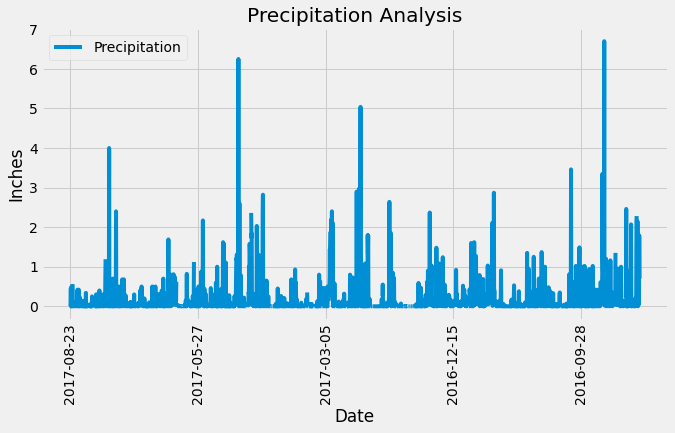

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(title='Precipitation Analysis', figsize=(10,5))

# Set xticks
plt.xticks(rotation = 'vertical')

# Adjust legend
plt.legend(loc='upper left')

# Label x and y
plt.xlabel('Date')
plt.ylabel('Inches')

# Plot
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#  Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(measurement.station).distinct().count()
station_count

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
temps

[(54.0, 85.0, 71.66378066378067)]

In [20]:
temps_df=pd.DataFrame(temps, columns=['Min','Max', 'Avg'])
temps_df

,Min,Max,Avg
0,54.0,85.0,71.663781


In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
most_active_one_year = dt.date(2017,8,23) - dt.timedelta(days=365)
most_active_temp = session.query(measurement.date, measurement.tobs).\
                            filter(measurement.station == 'USC00519281').\
                            filter(measurement.date>=most_active_one_year)

most_active_temp_df=pd.DataFrame(most_active_temp, columns=['Date','Temperature'])
most_active_temp_df

,Date,Temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


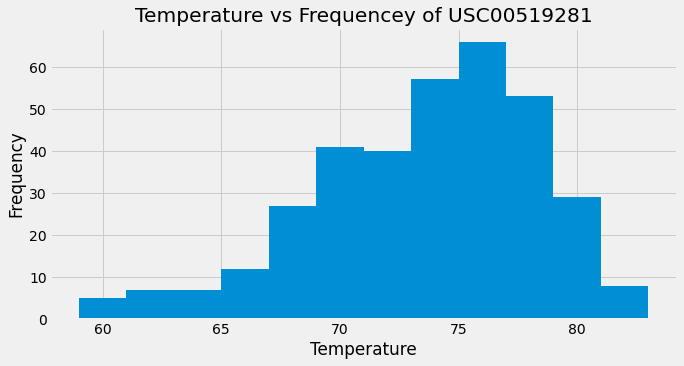

In [22]:
# Plot the results as a histogram
temp_hist = most_active_temp_df.hist(bins=12, figsize=(10,5))

# Label x, y, and title
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title("Temperature vs Frequencey of USC00519281")

# Show histogram
plt.show()

#  Close session

In [23]:
# Close Session
session.close()